# Group Details

## Group Name:

### Student 1:

### Student 2:

### Student 3:

# Loading Data and Preliminaries

In [1]:
%cd /content/drive/MyDrive/TUe/DeepLearning/Assignment2

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/TUe/DeepLearning/Assignment2'
d:\DSAI-22-24\TUe-Year1\Q4\Deep Learning\Deep-learning\assignment_2


In [2]:
import os

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
#from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

In [3]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


# Data Handling and Preprocessing

In [4]:
def pad_array(data):
    # Pad the array with zeros if necessary to have 9 rows
    padded_input_data  = np.pad(data[0], ((0, 9 - data[0].shape[0]), (0, 0)), mode='constant')
    padded_target_data = np.pad(data[1], ((0, 9 - data[1].shape[0]), (0, 0)), mode='constant')
    return torch.tensor(padded_input_data, dtype=torch.float32), torch.tensor(padded_target_data, dtype=torch.float32)

def create_mask(data,padded_input_data):
    # Create a boolean mask array indicating the padded rows
    mask = np.ones_like(padded_input_data, dtype=bool)
    mask[data[0].shape[0]:] = False
    return torch.tensor(mask, dtype=torch.bool)

def pair_values(data):
    # Pair up the values of the same columns from every row with every other row
    num_rows, num_cols = data.shape
    padded_input_data = torch.zeros((num_rows, num_rows, num_cols, 2))

    for i in range(num_rows):
        pair_idx = 0
        for j in range(num_rows):

            padded_input_data[i, pair_idx, :, 0] = data[i]
            padded_input_data[i, pair_idx, :, 1] = data[j]
            pair_idx += 1

    return padded_input_data

def get_euclidean_distance(x):
    euclidean_distances = torch.zeros((len(x), len(x)))
    for i in range(len(x)):
        source_x, source_y= x[i][1], x[i][2]
        #euclidean_distance=[]
        for j in range(len(x)):
            target_x, target_y= x[j][1], x[j][2]
            euclidean_distances[i][j]=np.sqrt((source_x-target_x)**2+(source_y-target_y)**2)
            #euclidean_distance.append(np.sqrt((source_x-target_x)**2+(source_y-target_y)**2))
        #euclidean_distances.append(euclidean_distance)

    return euclidean_distances #list of lists

def target_difference(target_x, source_x):
    # target x and source x are of shape (9, 2)
    #Subtract the x and y coordinates of the target from the source
    return target_x - source_x


def process_file(file_path):
    # Main function to process a single file
    data = load_array(file_path, 'task 1')
    padded_input_data, padded_target_data = pad_array(data)
    mask = create_mask(data,padded_input_data)
    input_data = pair_values(padded_input_data)
    euclidean_distance = get_euclidean_distance(padded_input_data)
    target_data= target_difference(padded_target_data, padded_input_data[:,1:3])

    return input_data, target_data, padded_input_data, mask, euclidean_distance


In [5]:
class CustomDataset_2(Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.file_list = os.listdir(folder)

    def __len__(self):
        return len(self.file_list)

    def _read_file(self, file_path):
        input_data, target_data,data, mask, distances= process_file(file_path)
        return input_data, target_data,data, mask, distances

    def __getitem__(self, index):
        file_path = os.path.join(self.folder, self.file_list[index])
        # Read and preprocess the data from the file
        input_data, target_data,data, mask, distance = self._read_file(file_path)
        # Return the preprocessed data
        return input_data, target_data,data, mask, distance

# Model Implementation

## NPE implementation

In [6]:
class NPEEncoder(nn.Module):
    def __init__(self, hidden_units):
        super(NPEEncoder, self).__init__()
        self.pairwise_layer = nn.Linear(10, hidden_units, bias=False)
        self.feedforward = nn.Sequential(
            nn.Linear(hidden_units, 50, bias=False),
            nn.ReLU(),
            nn.Linear(50, 50, bias=False),
            nn.ReLU(),
            nn.Linear(50, 50, bias=False),
            nn.ReLU(),
            nn.Linear(50, 50, bias=False),
            nn.ReLU()
        )

    def forward(self, x):
        x= x.to(torch.float32)
        x = self.pairwise_layer(x)
        x = self.feedforward(x)
        return x

class NPEDecoder(nn.Module):
    def __init__(self):
        super(NPEDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(55, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [7]:
class NPEEncoder(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(NPEEncoder, self).__init__()
        self.pairwise_layer = nn.Linear(10, hidden_units, bias=False)
        self.feedforward = nn.Sequential(
            nn.Linear(hidden_units, 50, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 50, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 50, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 50, bias=False),
            nn.ReLU()
        )

    def forward(self, x):
        x= x.to(torch.float32)
        x = self.pairwise_layer(x)
        x = self.feedforward(x)
        return x

class NPEDecoder(nn.Module):
    def __init__(self, dropout_rate):
        super(NPEDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(55, 50),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [8]:
class NPEModel(nn.Module):
    def __init__(self, hidden_units, device, dropout_rate=0.0):
        super(NPEModel, self).__init__()
        self.encoder = NPEEncoder(hidden_units, dropout_rate)
        self.decoder = NPEDecoder(dropout_rate)
        self.device = device

    def forward(self, x,unpaired_data, mask, distance, neighborhood_threshold=5):
        decoder_input = []
        dist_mask = ((distance > 0) & (distance < neighborhood_threshold))
        for batch in range(x.size(0)):
            batch_data= x[batch]
            for body in range(batch_data.size(0)):
                if torch.all(mask[batch][body]==1):
                    focus_body = unpaired_data[batch][body]

                    if dist_mask[batch][body].any():
                        chunk = torch.flatten(x[batch][body][dist_mask[batch][body]],start_dim=1)
                        neighbor_encodings = torch.sum(self.encoder(chunk), dim=0)
                    else:
                        neighbor_encodings = torch.zeros(50).to(self.device)
                    # Concatenate the focus body encoding with the focus_body
                    decoder_input.append(torch.cat((neighbor_encodings, focus_body), dim=0))
                else:
                    decoder_input.append(torch.cat((torch.zeros(50, device=self.device), torch.zeros_like(unpaired_data[batch][body])), dim=0))

        # Decode the concatenated vector
        decoded = self.decoder(torch.stack(decoder_input))

        out_shape = x.size()
        decoded = decoded.view(out_shape[0], out_shape[1], -1)

        return decoded

# Model Training

## NPE training

In [9]:
def load_data(folder):
    file_list = os.listdir(folder)
    output = []

    for filename in file_list:
        file_path = os.path.join(folder, filename)
        output.append(process_file(file_path))

    return output

In [10]:
data_dir = 'data/task 1/train'
# dataset = CustomDataset_2(data_dir)

dataset = load_data(data_dir)


data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [11]:
test_data_dir = 'data/task 1/test'
# test_dataset = CustomDataset_2(test_data_dir)

test_dataset = load_data(test_data_dir)


test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [13]:
# Hyperparameters
hidden_units = 25
learning_rate = 1e-3
learning_rate_decay = 0.99
iterations = 50
batch_size = 100

# Create the model
model = NPEModel(hidden_units, device=device)
model.to(device)
criterion = nn.MSELoss(reduction='none')
# optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [14]:
def train_sim_model(model, train_data_loader, valid_data_loader, optimizer, criterion,
                    device=torch.device('cpu'), iterations=50, model_file='best_model.pth'):
    best_val_loss = np.inf
    for iteration in tqdm(range(iterations)):
        model.train()
        train_loss=0.0
        for input_data, target_data,unpaired_data, mask, distance in train_data_loader:
        # Training steps
            input_data = input_data.to(device)
            unpaired_data = unpaired_data.to(device)
            mask = mask.to(device)
            distance = distance.to(device)
            target_data=target_data.to(device)

            optimizer.zero_grad()
            output = model(input_data, unpaired_data, mask, distance)

            loss = torch.masked_select(criterion(target_data, output),
                                       torch.stack([mask.all(dim=2), mask.all(dim=2)], dim=2)).mean()
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_data_loader)


        model.eval()
        test_loss=0.0
        with torch.no_grad():
            for input_data, target_data,unpaired_data, mask, distance in valid_data_loader:
                input_data = input_data.to(device)
                target_data = target_data.to(device)
                unpaired_data = unpaired_data.to(device)
                mask = mask.to(device)
                distance = distance.to(device)

                output = model(input_data, unpaired_data, mask, distance)
                loss = torch.masked_select(criterion(target_data, output),
                                       torch.stack([mask.all(dim=2), mask.all(dim=2)], dim=2)).mean()
                test_loss += loss.item()
        test_loss /= len(valid_data_loader)

        if test_loss < best_val_loss:
            best_val_loss = test_loss
            torch.save({
                'epoch': iteration+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, model_file)


            # Print loss for monitoring
            #if (iteration + 1) % 10000 == 0:
        print(f"Epoch [{iteration+1}/{iterations}], Loss: {train_loss}, \tTest Loss: {test_loss}")

In [ ]:
train_sim_model(model, data_loader, test_data_loader, optimizer, criterion, device=device, iterations=iterations)

# Data processing for tasks 2 and 3

In [18]:
def files_2_data(files):
    output = []
    for file_path in tqdm(files):
        datapoint = np.load(file_path)
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        for i in range(whole_trajectory.shape[1] - 1):
            data = whole_trajectory[:, i], whole_trajectory[:, i + 1, 1:3]
            padded_input_data, padded_target_data = pad_array(data)
            mask = create_mask(data,padded_input_data)
            input_data = pair_values(padded_input_data)
            euclidean_distance = get_euclidean_distance(padded_input_data)
            target_data= target_difference(padded_target_data, padded_input_data[:,1:3])

            output.append((input_data, target_data, padded_input_data, mask, euclidean_distance))
    return output

In [15]:
files_rate = 0.1

train_files = glob('data/task 2_3/train/*')
train_files = train_files[:int(len(train_files) * files_rate)]

train_files, valid_files = train_test_split(train_files, train_size=0.7)

In [17]:
train_data = files_2_data(train_files)

valid_data = files_2_data(valid_files)

  8%|▊         | 5/62 [00:02<00:30,  1.88it/s]


KeyboardInterrupt: 

In [ ]:
len(train_data)

3038

In [ ]:
BATCH_SIZE = 256

train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Task 2

In [ ]:
# Hyperparameters
hidden_units = 25
LR = 1e-3
EPOCHS = 20

# Create the model
model = NPEModel(hidden_units, device=device).to(device)

criterion = nn.MSELoss(reduction='none')
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [ ]:
train_sim_model(model, train_data_loader, valid_data_loader, optimizer, criterion, device, iterations=EPOCHS, model_file='best_task2_model.pth')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.003398599378256635, Test Loss: 0.0016338409264930165
Epoch [2/20], Loss: 0.001405528492548249, Test Loss: 0.0015441631761719831
Epoch [3/20], Loss: 0.0013693399474309558, Test Loss: 0.001541016067046887
Epoch [4/20], Loss: 0.0013417389969272186, Test Loss: 0.0014802648474869784
Epoch [5/20], Loss: 0.0012797547084825837, Test Loss: 0.0013887820580119016
Epoch [6/20], Loss: 0.0011059089081769825, Test Loss: 0.0011082712911817138
Epoch [7/20], Loss: 0.0006842164049494611, Test Loss: 0.0005050683561981154
Epoch [8/20], Loss: 0.0003725812120520902, Test Loss: 0.0003778186411671833
Epoch [9/20], Loss: 0.00030229988732579174, Test Loss: 0.00036843588273208856
Epoch [10/20], Loss: 0.0002553232464206228, Test Loss: 0.00034135403494964033
Epoch [11/20], Loss: 0.00023656424093117923, Test Loss: 0.000310722683025233
Epoch [12/20], Loss: 0.00022943207542152214, Test Loss: 0.00028460369818416296
Epoch [13/20], Loss: 0.00021656104993683187, Test Loss: 0.0002697003819076389
Epoch

In [ ]:
def recalc_data(padded_input_data):
    input_data = []
    euclidean_distance = []
    for elem in padded_input_data:
        input_data.append(pair_values(elem))
        euclidean_distance.append(get_euclidean_distance(elem))

    return torch.stack(input_data), padded_input_data, torch.stack(euclidean_distance)

In [ ]:
def simulate(init_data, times=5):
    input_data, unpaired_data, mask, distance = init_data

    input_data = input_data.to(device).unsqueeze(0)
    unpaired_data = unpaired_data.to(device).unsqueeze(0)
    mask = mask.to(device).unsqueeze(0)
    distance = distance.to(device).unsqueeze(0)

    locations = []
    model.eval()
    with torch.no_grad():
        for time in tqdm(range(times)):

            output = model(input_data, unpaired_data, mask, distance).squeeze(0)

            unpaired_data[:,:,3:5] = output
            unpaired_data[:,:,1:3] += unpaired_data[:,:,3:5]
            locations.append(unpaired_data[:,:,1:3])

            input_data, unpaired_data, distance = recalc_data(unpaired_data)


    return locations

In [ ]:
test_files = glob('data/task 2_3/test/*')

# Task 3

In [16]:
# Hyperparameters
hidden_units = 25
LR = 1e-3
EPOCHS = 20

# Create the model
model = NPEModel(hidden_units, device=device, dropout_rate=0.3).to(device)

criterion = nn.MSELoss(reduction='none')
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [ ]:
train_sim_model(model, train_data_loader, valid_data_loader, optimizer, criterion, device, iterations=EPOCHS, model_file='best_task3_model.pth')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.0183174058329314, 	Test Loss: 0.012619451619684696
Epoch [2/20], Loss: 0.01454673622113963, 	Test Loss: 0.011392138820762435
Epoch [3/20], Loss: 0.01237414552209278, 	Test Loss: 0.009103614293659726
Epoch [4/20], Loss: 0.010398980074872574, 	Test Loss: 0.006704504368826747
Epoch [5/20], Loss: 0.00843695019527028, 	Test Loss: 0.004439216029519836
Epoch [6/20], Loss: 0.007162823885058363, 	Test Loss: 0.003586525834786395
Epoch [7/20], Loss: 0.006411579709189634, 	Test Loss: 0.0028222805509964624
Epoch [8/20], Loss: 0.00572050386108458, 	Test Loss: 0.0027728600543923676
Epoch [9/20], Loss: 0.005268198049937685, 	Test Loss: 0.0024894396774470806
Epoch [10/20], Loss: 0.005004057621893783, 	Test Loss: 0.0023303597311799726
Epoch [11/20], Loss: 0.004800411096463601, 	Test Loss: 0.002275079799195131
Epoch [12/20], Loss: 0.004502329509705305, 	Test Loss: 0.0022224029138063392
Epoch [13/20], Loss: 0.004438457971749206, 	Test Loss: 0.002198931877501309
Epoch [14/20], Loss: 0

In [19]:
test_files = glob('data/task 2_3/test/*')
test_files = test_files[:int(len(test_files) * files_rate)]
test_data = files_2_data(test_files)

100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


In [20]:
def mc_dropout_sim(model, batch, times = 100):
    input_data, target_data,unpaired_data, mask, distance = batch
    input_data = input_data.to(device)
    target_data = target_data.to(device)
    unpaired_data = unpaired_data.to(device)
    mask = mask.to(device)
    distance = distance.to(device)
    sim_results = []
    unpaired_list_data=unpaired_data.squeeze(0).cpu().numpy()
    unpaired_list_data=unpaired_list_data[:,:2]
    target_list_data=target_data.squeeze(0).cpu().numpy()
    target_list_data=target_list_data[:,:2]

    model.train()
    with torch.no_grad():
        for time in tqdm(range(times)):
            output = model(input_data, unpaired_data, mask, distance)
            sim_results.append(output)
            
    sim_results = torch.stack(sim_results)
    return sim_results.permute(1, 2, 0, 3), unpaired_list_data, target_list_data

In [21]:
BATCH_SIZE = 1

test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
input_data, target_data,unpaired_data, mask, distance = next(iter(test_data_loader))

In [23]:
sim_results, initial_position,target_position = mc_dropout_sim(model, next(iter(test_data_loader)), times = 1000)

100%|██████████| 1000/1000 [00:12<00:00, 82.97it/s]


# Evaluation

In [24]:
sim_results= sim_results.squeeze().cpu().numpy()

In [25]:
dummy_array = sim_results + initial_position[:, None, :]

In [26]:
dummy_array= np.delete(dummy_array, 8, axis=0)

In [27]:
final_position= np.copy(dummy_array)

In [28]:
final_position_x= final_position[:,:,0]
final_position_y= final_position[:,:,1]

In [29]:
target_position = target_position + initial_position

In [30]:
target_position_x= target_position[:,0]
target_position_y= target_position[:,1]

In [31]:
def get_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std= np.std(data)

    lower_bound = np.percentile(data, (1-confidence)/2*100)
    upper_bound = np.percentile(data, (1+confidence)/2*100)

    return lower_bound, upper_bound

In [63]:
# create subplots of shape (1,2)
def plot_for_a_body(x_position, y_position,target_x,target_y, body=0):
    fig, ax = plt.subplots(8, 2, figsize=(15, 20))

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            if j==0:
                lower_bound, upper_bound = get_confidence_interval(x_position[i])
                col.hist(x_position[i], bins=10, edgecolor='black', alpha=0.7, label='Data')
                col.axvspan(lower_bound, upper_bound, alpha=0.3, color='gray', label='90% Confidence Interval')
                col.axvline(target_x[i], color='red', linestyle='dashed', linewidth=1, label='True Value')
                col.axvline(np.mean(x_position[i]), color='black', linestyle='dashed', linewidth=1, label='Mean')
                col.axvline(lower_bound, color='gray', linewidth=1, label='Lower Bound')
                col.axvline(upper_bound, color='gray', linewidth=1, label='Upper Bound')
                col.set_title(f'Body : {i+1}')
                col.set_xlabel('X Position')
                col.set_ylabel('Observations')
                col.legend()
            else:

            
                lower_bound, upper_bound = get_confidence_interval(y_position[i])
                col.hist(y_position[i], bins=10, edgecolor='black', alpha=0.7, label='Data')
                col.axvspan(lower_bound, upper_bound, alpha=0.3, color='gray', label='90% Confidence Interval')
                col.axvline(target_y[i], color='red', linestyle='dashed', linewidth=1, label='True Value')
                col.axvline(np.mean(y_position[i]), color='black', linestyle='dashed', linewidth=1, label='Mean')
                col.axvline(lower_bound, color='gray', linewidth=1, label='Lower Bound')
                col.axvline(upper_bound, color='gray', linewidth=1, label='Upper Bound')
                col.set_title(f'Body : {i+1}')
                col.set_xlabel('Y Position')
                col.set_ylabel('Observations')
                col.legend()

    #main title 
    fig.subplots_adjust(top=0.92, hspace=0.5)
    fig.suptitle(f'95 % confidence intervals for 1000 observations')
    #fig.tight_layout()

    plt.show()

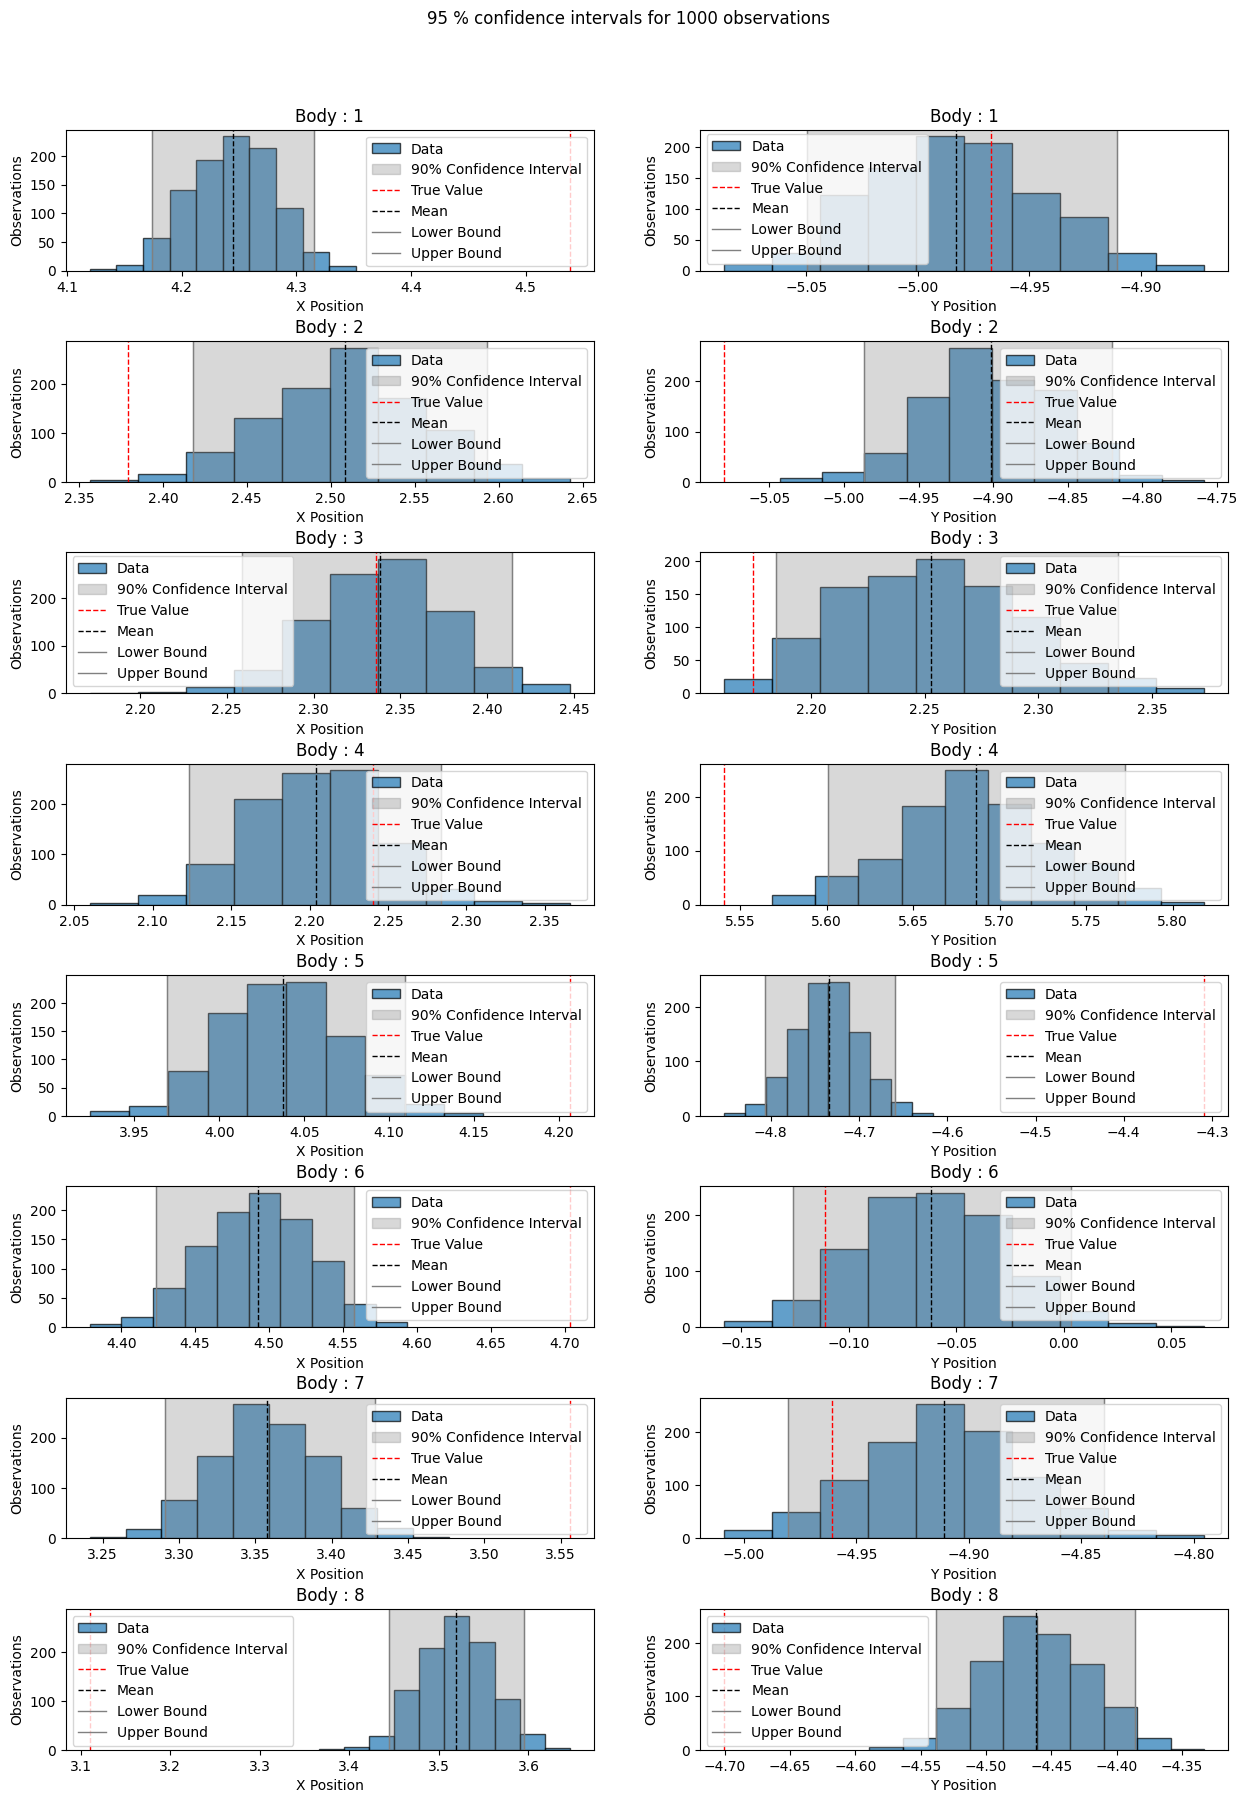

In [64]:
plot_for_a_body(final_position_x, final_position_y,target_position_x,target_position_y, body=0)

In [43]:
def plot_body(x_position, y_position,target_x,target_y, body=0):    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    lower_bound, upper_bound = get_confidence_interval(x_position)
    ax[0].hist(x_position, bins=10, edgecolor='black', alpha=0.7, label='Data')
    ax[0].axvspan(lower_bound, upper_bound, alpha=0.3, color='gray', label='90% Confidence Interval')
    ax[0].axvline(target_x, color='red', linestyle='dashed', linewidth=1, label='True Value')
    ax[0].axvline(np.mean(x_position), color='black', linestyle='dashed', linewidth=1, label='Mean')
    ax[0].axvline(lower_bound, color='gray', linewidth=1, label='Lower Bound')
    ax[0].axvline(upper_bound, color='gray', linewidth=1, label='Upper Bound')
    ax[0].set_title(f'Body : {body}')
    ax[0].set_xlabel('X Position')
    ax[0].set_ylabel('Observations')
    ax[0].legend()

    lower_bound, upper_bound = get_confidence_interval(y_position)
    ax[1].hist(y_position, bins=10, edgecolor='black', alpha=0.7, label='Data')
    ax[1].axvspan(lower_bound, upper_bound, alpha=0.3, color='gray', label='90% Confidence Interval')
    ax[1].axvline(target_y, color='red', linestyle='dashed', linewidth=1, label='True Value')
    ax[1].axvline(np.mean(y_position), color='black', linestyle='dashed', linewidth=1, label='Mean')
    ax[1].axvline(lower_bound, color='gray', linewidth=1, label='Lower Bound')
    ax[1].axvline(upper_bound, color='gray', linewidth=1, label='Upper Bound')
    ax[1].set_title(f'Body : {body}')
    ax[1].set_xlabel('Y Position')
    ax[1].set_ylabel('Observations')
    ax[1].legend()

    #main title 
    fig.suptitle(f'95 % confidence intervals for 1000 observations')

plt.show()

In [47]:
final_position_y[0]

array([-4.929458 , -4.9145217, -5.0187   , -5.00248  , -4.9845786,
       -5.041447 , -4.9888372, -4.9246964, -4.9926023, -4.9971466,
       -4.9826202, -4.9922395, -4.987263 , -4.971324 , -5.003556 ,
       -5.007003 , -4.9723883, -5.0131564, -5.007345 , -4.9743385,
       -4.961874 , -5.023478 , -4.979779 , -5.04103  , -4.8905168,
       -4.966671 , -4.9308734, -4.986773 , -5.019227 , -5.002008 ,
       -4.961636 , -4.995786 , -4.9726763, -5.0074635, -4.929625 ,
       -4.9743814, -4.975334 , -4.9393415, -4.9431095, -5.003446 ,
       -4.9839377, -4.9352503, -4.9762354, -5.0351105, -5.0405884,
       -4.9414754, -4.9609413, -4.9705224, -4.9636555, -4.9907203,
       -4.9302278, -5.039265 , -4.9988194, -4.951898 , -4.96186  ,
       -5.0034237, -4.970706 , -4.962325 , -4.995652 , -4.953642 ,
       -4.9437203, -4.92465  , -4.957148 , -5.026886 , -5.050385 ,
       -4.9458537, -4.9919314, -4.9705553, -4.97646  , -4.990192 ,
       -4.999471 , -4.996551 , -5.036742 , -4.968191 , -4.9778

" mean = np.mean(position)\nstd = np.std(position)\n\n\n#calculate the 90% confidence interval\nlower_bound= np.percentile(position, 5)\nupper_bound= np.percentile(position, 95)\n\nplt.hist(position, bins=10, edgecolor='black', alpha=0.7, label='Data')\n\n# Plot the confidence interval\nplt.axvspan(lower_bound, upper_bound, alpha=0.3, color='gray', label='90% Confidence Interval')\n#dotted line at the mean\nplt.axvline(target_position_x[0], color='red', linestyle='dashed', linewidth=1, label='True Value')\nplt.axvline(mean, color='black', linestyle='dashed', linewidth=1, label='Mean')\n\n#vertical line at the lower bound and upper bound\nplt.axvline(lower_bound, color='gray', linewidth=1, label='Lower Bound')\nplt.axvline(upper_bound, color='gray', linewidth=1, label='Upper Bound')\n\n#set the x-axis limit\n\n#plt.xlim(3.75,4.95)\n# Customize the plot\nplt.xlabel('Value')\nplt.ylabel('Number of Observations')\nplt.legend()\nplt.title('90' '%'f' confidence interval for X Coordinate of B

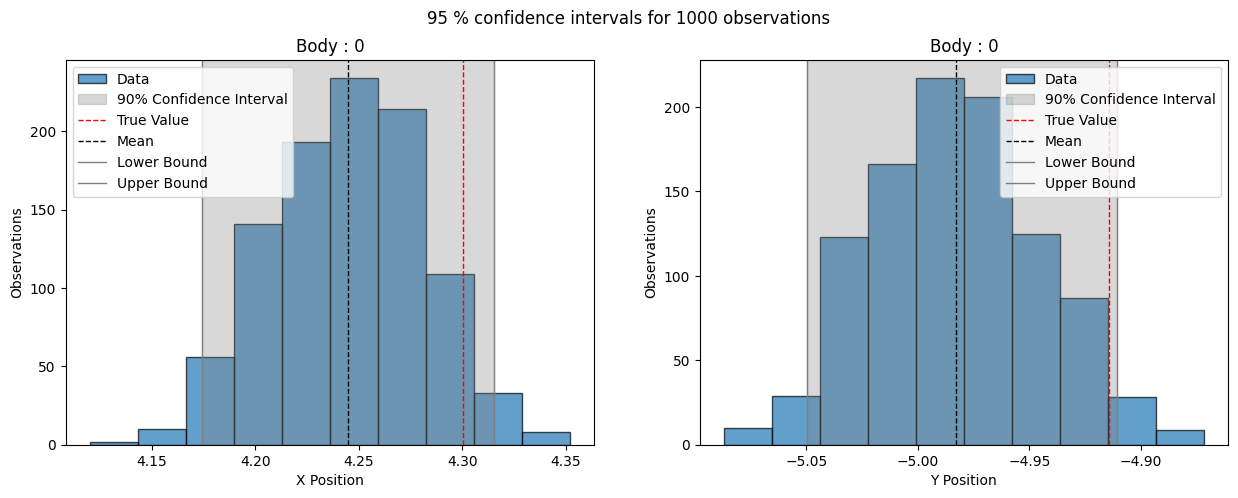

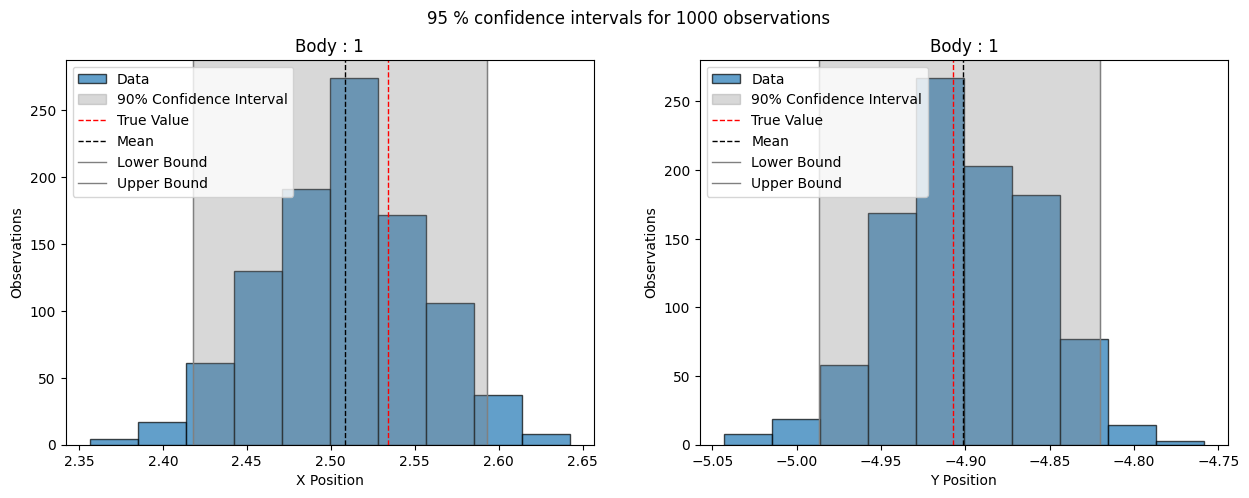

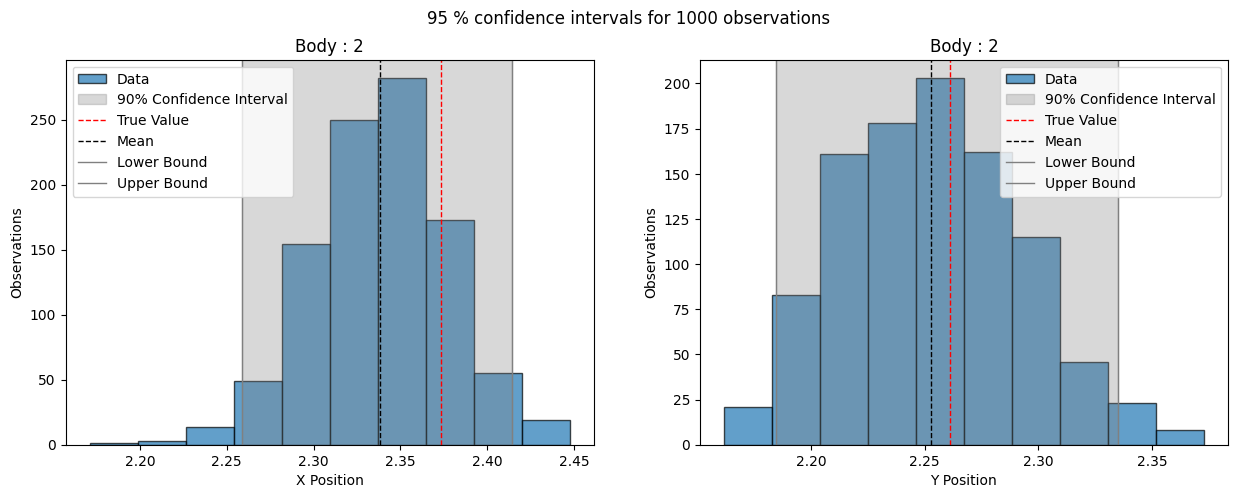

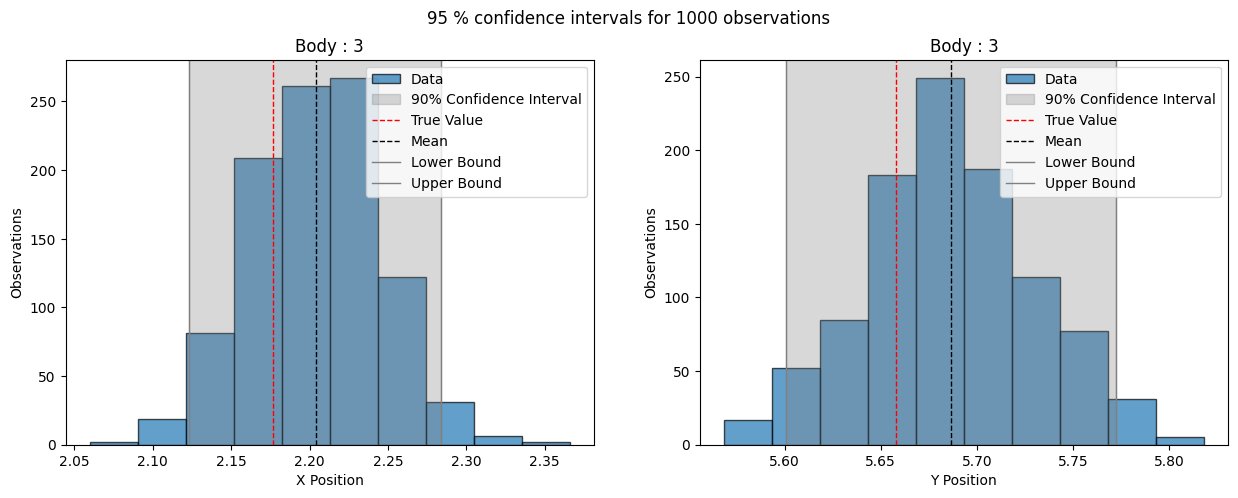

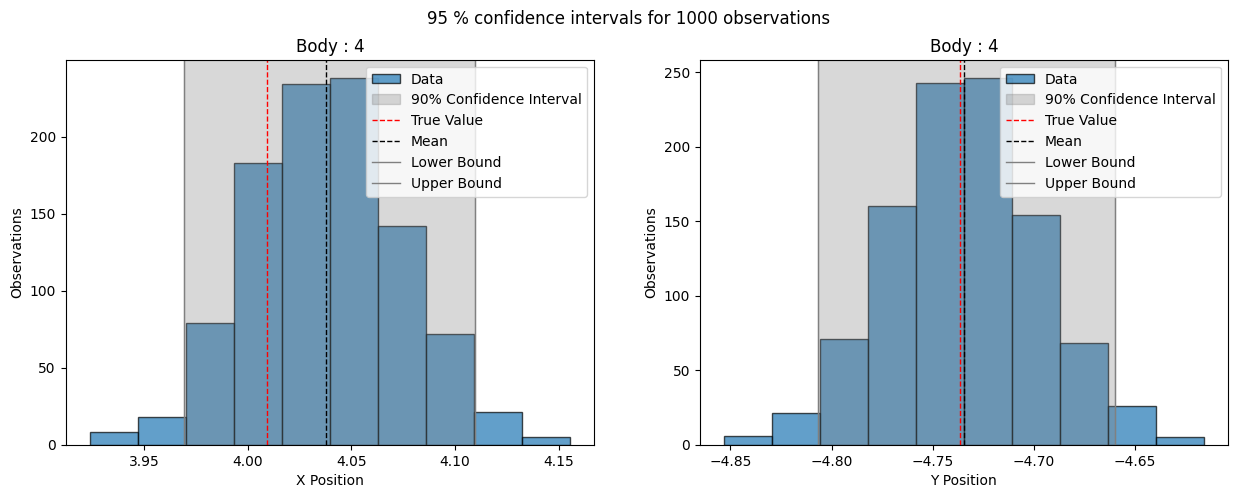

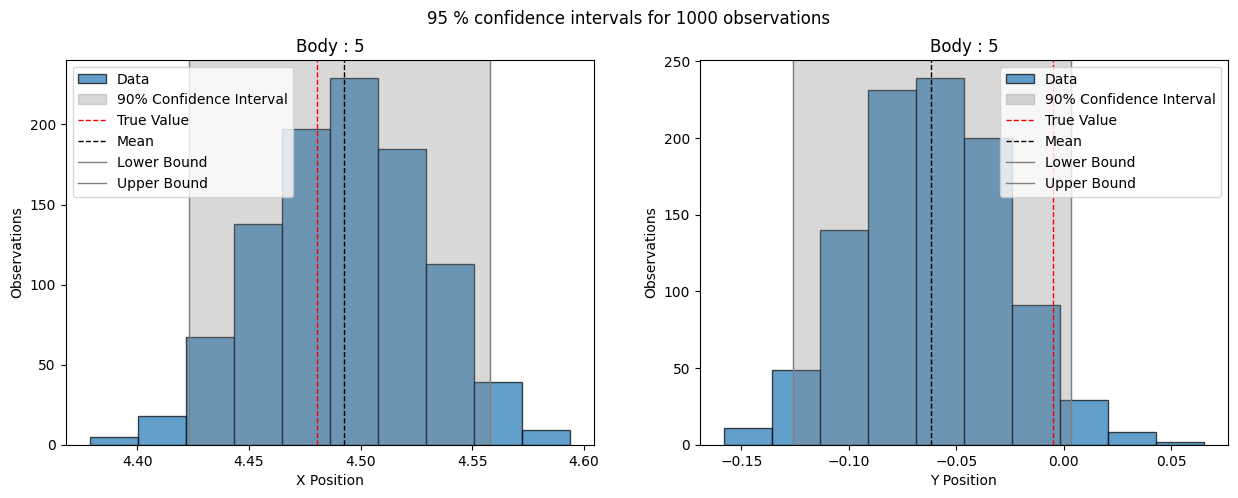

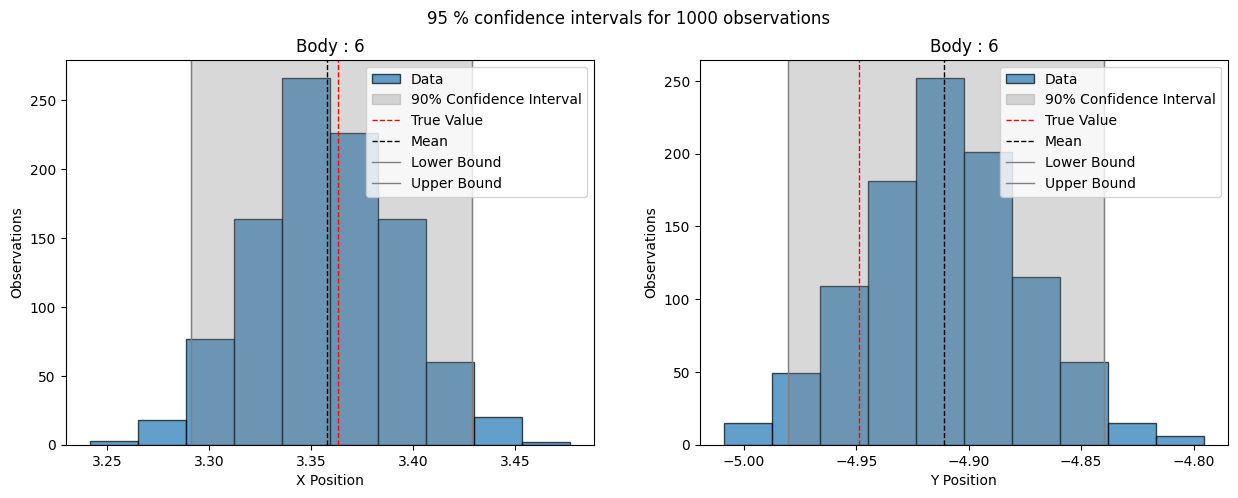

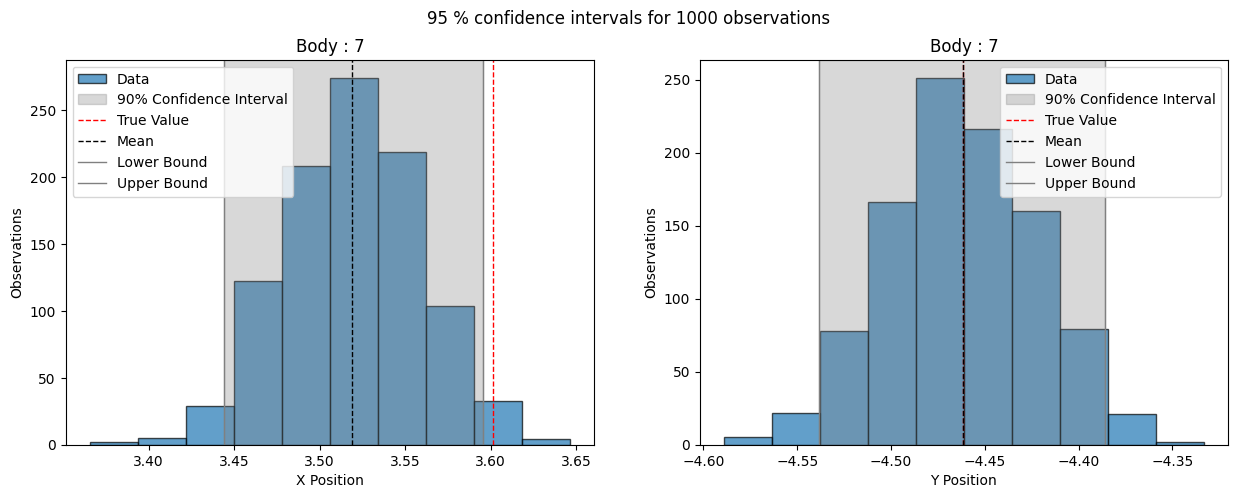

In [45]:
i=0
for position_x, position_y in zip(final_position_x, final_position_y):
    plot_body(position_x, position_y,final_position_x[i][0],final_position_y[i][1],i)
    i+=1


""" mean = np.mean(position)
std = np.std(position)


#calculate the 90% confidence interval
lower_bound= np.percentile(position, 5)
upper_bound= np.percentile(position, 95)

plt.hist(position, bins=10, edgecolor='black', alpha=0.7, label='Data')

# Plot the confidence interval
plt.axvspan(lower_bound, upper_bound, alpha=0.3, color='gray', label='90% Confidence Interval')
#dotted line at the mean
plt.axvline(target_position_x[0], color='red', linestyle='dashed', linewidth=1, label='True Value')
plt.axvline(mean, color='black', linestyle='dashed', linewidth=1, label='Mean')

#vertical line at the lower bound and upper bound
plt.axvline(lower_bound, color='gray', linewidth=1, label='Lower Bound')
plt.axvline(upper_bound, color='gray', linewidth=1, label='Upper Bound')

#set the x-axis limit

#plt.xlim(3.75,4.95)
# Customize the plot
plt.xlabel('Value')
plt.ylabel('Number of Observations')
plt.legend()
plt.title('90' '%'f' confidence interval for X Coordinate of Body {i+1}')

# Show the plot
plt.show() """